In [22]:

from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, VotingClassifier, AdaBoostClassifier, BaggingRegressor
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score, roc_curve, precision_score, recall_score, precision_recall_curve,f1_score
import seaborn as sns
import matplotlib.pyplot as plt

import xgboost as xgb

import plotly.plotly as py
import plotly.figure_factory as ff
import plotly.graph_objs as go
import plotly.tools

import pandas as pd
import numpy as np
import pickle
plotly.tools.set_credentials_file(username='aggittle', api_key='s7oM3A2McD0WjOeYpHQ0')

pd.options.display.max_columns = None

In [23]:
msd_reggae = pd.read_pickle('msd_csvs/spotify_reggae_df.pkl')
msd_country = pd.read_pickle('msd_csvs/spotify_country_df.pkl')
msd_folk = pd.read_pickle('msd_csvs/spotify_folk_df.pkl')
msd_rnb = pd.read_pickle('msd_csvs/spotify_rnb_df.pkl')
msd_rap = pd.read_csv('msd_csvs/msd_rap.csv')
msd_jazz = pd.read_csv('msd_csvs/msd_jazz.csv')
msd_latin = pd.read_csv('msd_csvs/msd_latin.csv')
msd_vocal = pd.read_pickle('msd_csvs/spotify_vocal_df.pkl')
msd_blues = pd.read_pickle('msd_csvs/spotify_blues_df.pkl')

(print(f"Reggae: {len(msd_reggae)} rows, Country: {len(msd_country)} rows, Rap: {len(msd_rap)} rows, Folk: {len(msd_folk)} rows, RnB: {len(msd_rnb)} rows, Latin: {len(msd_latin)} rows, Jazz: {len(msd_jazz)} rows, Blues: {len(msd_blues)} rows, Vocal: {len(msd_vocal)} rows"))
msd_dfs = [ msd_country, msd_folk, msd_blues]

Reggae: 3877 rows, Country: 5968 rows, Rap: 9958 rows, Folk: 3094 rows, RnB: 6457 rows, Latin: 8356 rows, Jazz: 8402 rows, Blues: 3702 rows, Vocal: 2232 rows


Let's see how well we can classify more closely-related genres

# Country, Folk, and Blues

In [3]:
drops = ['offset_seconds','window_seconds', 'analysis_sample_rate', 'analysis_channels','code_version',
         'echoprint_version','synch_version','rhythm_version', 'mode_confidence', 'key_confidence',
        'key', 'duration', 'duration_ms', 'num_samples', 'mode']

msddf = pd.concat(msd_dfs, ignore_index=True).dropna().drop(drops, axis=1).drop_duplicates(subset=['name','track'])

In [4]:
#sns.pairplot(msddf, hue='genre')

In [5]:
X = msddf.drop('genre',axis=1)
y = msddf.genre

X_train, X_test_names, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=2)
X_train_names, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=25)

X_test = X_test_names.drop(['name','track'],axis=1)
X_train = X_train_names.drop(['name','track'],axis=1)
X_val = X_val.drop(['name','track'],axis=1)

In [6]:
labels = ['blues', 'country', 'folk',]

In [7]:
forest = RandomForestClassifier(n_estimators=500, max_depth = 50)
forest.fit(X_train, y_train)
print("Random Forest")
print(f"Training: {forest.score(X_train, y_train)}")
print(f"Test: {forest.score(X_test, y_test)}")

Random Forest
Training: 1.0
Test: 0.643053267435475


In [8]:
print('Metrics for Random Forest:')
print(labels)
p = precision_score(y_test, forest.predict(X_test), average=None, labels=labels)
r = recall_score(y_test, forest.predict(X_test), average=None, labels=labels)
f1 = f1_score(y_test, forest.predict(X_test), average=None, labels=labels)
print(f"Precision: {p},\n Recall: {r},\n F1: {f1}")

Metrics for Random Forest:
['blues', 'country', 'folk']
Precision: [0.65101721 0.69934641 0.57368421],
 Recall: [0.70508475 0.65343511 0.56770833],
 F1: [0.67697315 0.67561168 0.57068063]


[[416  66 108]
 [ 92 428 135]
 [131 118 327]]


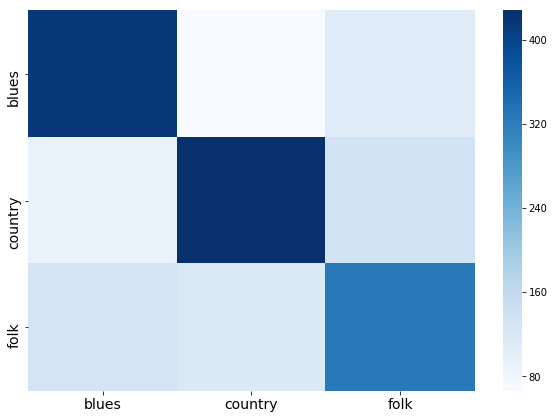

In [9]:
conf_matrix =  confusion_matrix(y_test, forest.predict(X_test), labels=labels);
print(conf_matrix)
plt.figure(figsize=(10,7))
plt.xticks(size=14)
plt.yticks(size=14, rotation=45)
sns.heatmap(conf_matrix, cmap='Blues', xticklabels=labels, yticklabels=labels);

In [10]:
gbm = xgb.XGBClassifier( 
                        n_estimators=30000,
                        max_depth=9,
                        objective='multi:softmax', 
                        num_class=6,
                        learning_rate=.05, 
                        subsample=.8,
                        min_child_weight=3,
                        colsample_bytree=.8,
                        gamma = .5
                       )

eval_set=[(X_train,y_train),(X_val,y_val)]
fit_model = gbm.fit( 
                    X_train, y_train, 
                    eval_set=eval_set,
                    eval_metric='mlogloss', 
                    early_stopping_rounds=1000,
                    verbose=False
                   )

accuracy_score(y_test, fit_model.predict(X_test, ntree_limit=gbm.best_ntree_limit)) 

0.6490939044481054

In [11]:
print('Metrics for Gradient Boost:')
print(labels)
p = precision_score(y_test, gbm.predict(X_test), average=None, labels=labels)
r = recall_score(y_test, gbm.predict(X_test), average=None, labels=labels)
f1 = f1_score(y_test, gbm.predict(X_test), average=None, labels=labels)
print(f"Precision: {p},\n Recall: {r},\n F1: {f1}")

Metrics for Gradient Boost:
['blues', 'country', 'folk']
Precision: [0.66775777 0.70394737 0.57475083],
 Recall: [0.69152542 0.65343511 0.60069444],
 F1: [0.67943381 0.67775139 0.58743633]


[[408  69 113]
 [ 84 428 143]
 [119 111 346]]


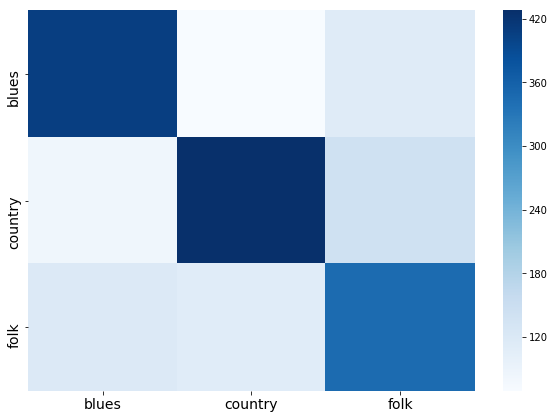

In [12]:
conf_matrix =  confusion_matrix(y_test, gbm.predict(X_test), labels=labels);
print(conf_matrix)
plt.figure(figsize=(10,7))
plt.xticks(size=14)
plt.yticks(size=14, rotation=45)
sns.heatmap(conf_matrix, cmap='Blues', xticklabels=labels, yticklabels=labels);

# Dance music

In [24]:
house = pd.read_csv('csvs/house.csv')
trance = pd.read_csv('csvs/trance.csv')
dnb = pd.read_csv('csvs/dnb.csv')
dubstep = pd.read_csv('csvs/dubstep.csv')
edm_csvs = [trance, house, dnb, dubstep]
drops = ['offset_seconds','window_seconds', 'analysis_sample_rate', 'analysis_channels','code_version',
         'echoprint_version','synch_version','rhythm_version', 'mode_confidence', 'key_confidence',
        'key', 'duration', 'duration_ms', 'num_samples', 'mode','Unnamed: 0']



edm = pd.concat(edm_csvs, ignore_index=True).drop(drops, axis=1).drop_duplicates(subset=['name','track'])

In [7]:
print(f'House: {len(house)}, Trance: {len(trance)}, DnB: {len(dnb)}, Dubstep: {len(dubstep)}')

House: 1352, Trance: 1026, DnB: 1019, Dubstep: 1073


In [25]:
X = edm.drop('genre',axis=1)
y = edm.genre

X_train, X_test_names, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=2)
X_train_names, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=25)

X_test = X_test_names.drop(['name','track'],axis=1)
X_train = X_train_names.drop(['name','track'],axis=1)
X_val = X_val.drop(['name','track'],axis=1)

In [26]:
labels = ['drumnbass','dubstep', 'house', 'trance']

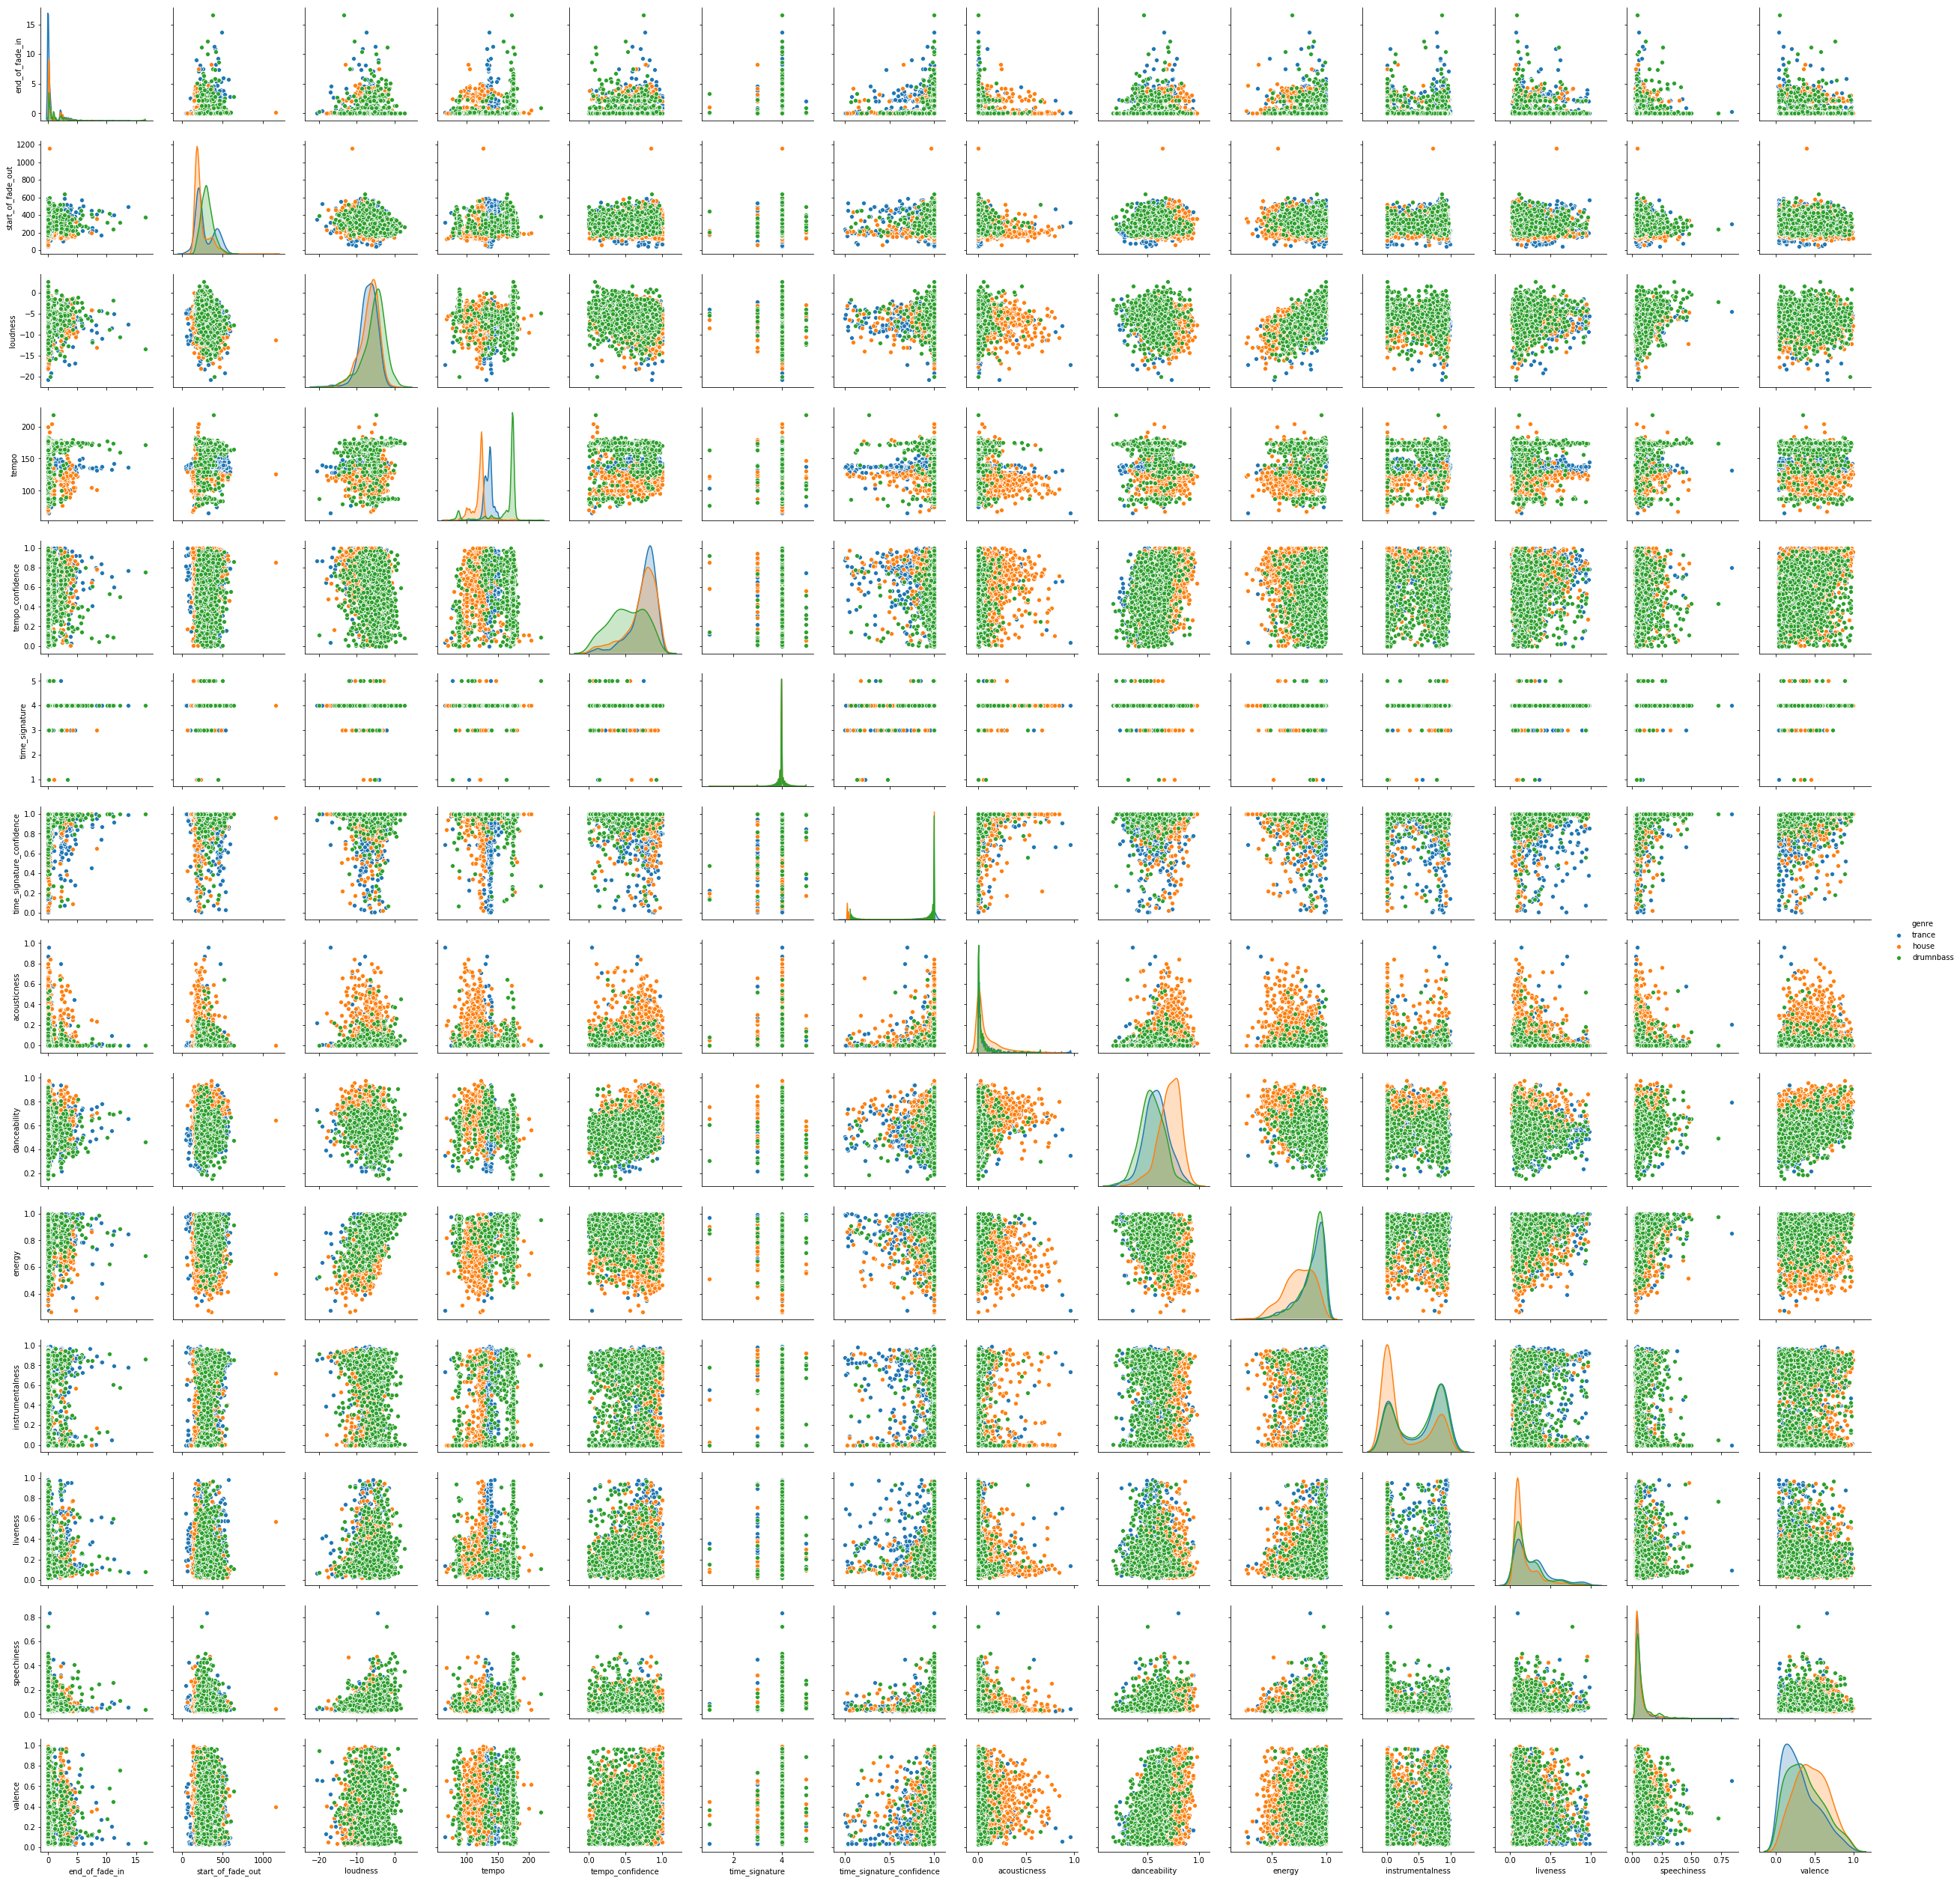

In [17]:
sns.pairplot(edm, hue='genre')

In [27]:
gbm = xgb.XGBClassifier( 
                        n_estimators=30000,
                        max_depth=9,
                        objective='multi:softmax', 
                        num_class=6,
                        learning_rate=.05, 
                        subsample=.8,
                        min_child_weight=3,
                        colsample_bytree=.8,
                        gamma = .5
                       )

eval_set=[(X_train,y_train),(X_val,y_val)]
fit_model = gbm.fit( 
                    X_train, y_train, 
                    eval_set=eval_set,
                    eval_metric='mlogloss', 
                    early_stopping_rounds=1000,
                    verbose=False
                   )

accuracy_score(y_test, fit_model.predict(X_test, ntree_limit=gbm.best_ntree_limit)) 

0.8661417322834646

In [28]:
print('Metrics for Gradient Boost:')
print(labels)
p = precision_score(y_test, gbm.predict(X_test), average=None, labels=labels)
r = recall_score(y_test, gbm.predict(X_test), average=None, labels=labels)
f1 = f1_score(y_test, gbm.predict(X_test), average=None, labels=labels)
print(f"Precision: {p},\n Recall: {r},\n F1: {f1}")

Metrics for Gradient Boost:
['drumnbass', 'dubstep', 'house', 'trance']
Precision: [0.90860215 0.8097561  0.85017422 0.90521327],
 Recall: [0.87113402 0.8097561  0.91044776 0.86036036],
 F1: [0.88947368 0.8097561  0.87927928 0.88221709]


In [29]:
metricsdf = pd.DataFrame([p,r,f1], index= ['precision','recall','f1'], columns=labels)

In [31]:
metricsdf.to_csv('dancemetrics.csv')

[[169  13   8   4]
 [ 11 166  19   9]
 [  1  16 244   7]
 [  5  10  16 191]]


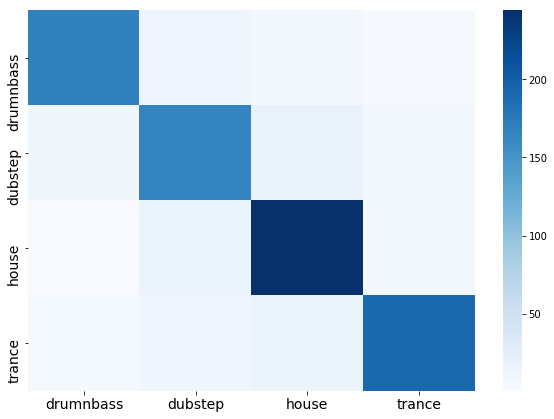

In [11]:
conf_matrix =  confusion_matrix(y_test, gbm.predict(X_test), labels=labels);
print(conf_matrix)
plt.figure(figsize=(10,7))
plt.xticks(size=14)
plt.yticks(size=14, rotation=45)
sns.heatmap(conf_matrix, cmap='Blues', xticklabels=labels, yticklabels=labels);

In [14]:
labels = ['Drum and Bass','Dubstep', 'House','Trance']
def get_dist_plot(feature):
    plt.figure(figsize=(10,8))
    sns.distplot(dnb[feature], label='Drum and Bass', hist=False, kde_kws={"shade": True})
    sns.distplot(house[feature], label='House', hist=False, kde_kws={"shade": True})
    sns.distplot(trance[feature], label='Trance', hist=False, kde_kws={"shade": True})
    sns.distplot(dubstep[feature], label='Dubstep', hist=False, kde_kws={"shade": True})
    plt.legend(loc='upper right', fontsize=14)
    plt.title(feature.capitalize()+' (Dance)', size=32)

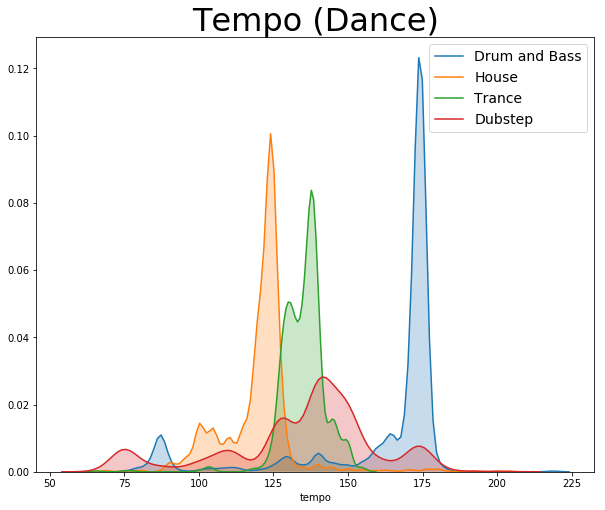

In [31]:
get_dist_plot('tempo')

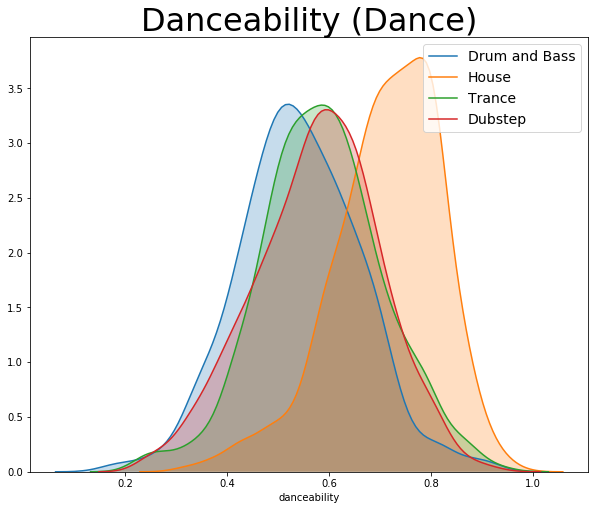

In [16]:
get_dist_plot('danceability')

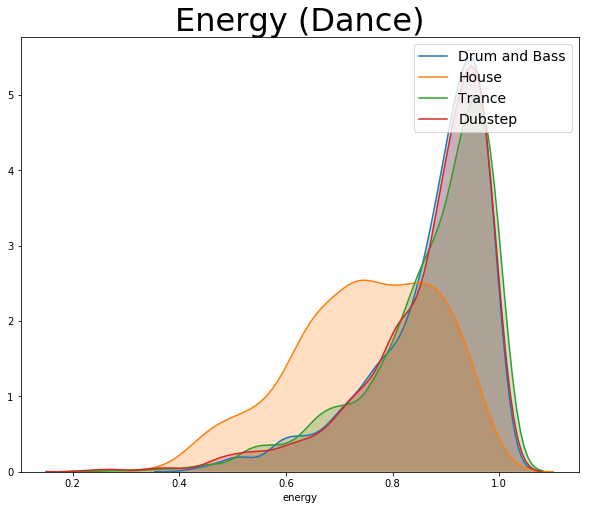

In [17]:
get_dist_plot('energy')

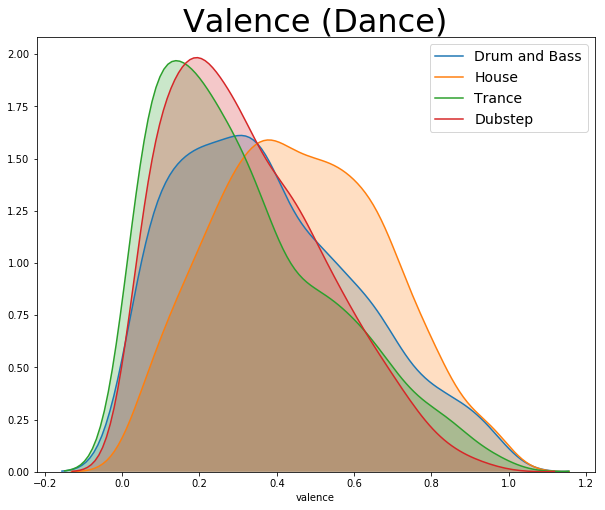

In [18]:
get_dist_plot('valence')

Let's pass our original Dance data set through our dance subgenre model and see how it performs. We can listen to songs with a probability of being in a given genre of 90% or more and gauge its accuracy subjectively. 

In [19]:
drops = ['offset_seconds','window_seconds', 'analysis_sample_rate', 'analysis_channels','code_version',
         'echoprint_version','synch_version','rhythm_version', 'mode_confidence', 'key_confidence',
        'key', 'duration', 'duration_ms', 'num_samples', 'mode', 'Unnamed: 0']


dance = pd.read_csv('csvs/dance.csv').drop(drops, axis=1)

In [20]:
dance_preds = gbm.predict_proba(dance.drop(['name', 'track', 'genre'], axis=1))

In [22]:
dance['prob_dnb'] = dance_preds[:,0]
dance['prob_dubstep'] = dance_preds[:,1]
dance['prob_house'] = dance_preds[:,2]
dance['prob_trance'] = dance_preds[:,3]




In [28]:
dance[(dance.prob_dnb>.9)].sort_values('prob_dnb', ascending=False)

,end_of_fade_in,start_of_fade_out,loudness,tempo,tempo_confidence,time_signature,time_signature_confidence,acousticness,danceability,energy,instrumentalness,liveness,speechiness,valence,name,track,genre,prob_dnb,prob_dubstep,prob_house,prob_trance
742,0.00000,389.97333,-5.131,172.019,0.645,4,0.995,0.00907,0.537,0.925,0.27900,0.2180,0.1550,0.6280,Mat Zo,Vice,dance,0.994618,0.003206,0.000851,0.001326
721,0.09288,281.04853,-4.928,173.975,0.568,4,0.995,0.00010,0.486,0.871,0.80600,0.1070,0.0447,0.2860,Metrik,Dawnbreaker,dance,0.994612,0.004438,0.000411,0.000539
630,0.00000,460.81161,-6.408,166.323,0.352,5,1.000,0.02460,0.513,0.623,0.00241,0.0695,0.0836,0.4980,Mobi Dixon,Love Colour Spin - Bossanova,dance,0.952601,0.027566,0.015389,0.004444
529,0.00000,200.23147,-2.082,171.959,0.402,4,1.000,0.00184,0.537,0.870,0.84500,0.1170,0.0437,0.0783,Topi,Under Control,dance,0.936560,0.056426,0.004136,0.002879


In [27]:
dance[(dance.prob_dubstep>.9)].sort_values('prob_dubstep', ascending=False)

,end_of_fade_in,start_of_fade_out,loudness,tempo,tempo_confidence,time_signature,time_signature_confidence,acousticness,danceability,energy,instrumentalness,liveness,speechiness,valence,name,track,genre,prob_dnb,prob_dubstep,prob_house,prob_trance
141,0.06966,214.14023,-3.685,152.919,0.268,4,0.994,0.057200,0.471,0.972,0.135000,0.3480,0.3970,0.3320,Nvdp,Come with Me,dance,0.002306,0.994620,0.000716,0.002357
1024,0.00000,213.47265,-1.658,75.196,0.134,4,0.982,0.023300,0.508,0.987,0.225000,0.1490,0.3500,0.3400,Kompany,Rapture,dance,0.003577,0.993382,0.001316,0.001724
1027,4.91683,242.53823,-3.839,149.936,0.153,4,0.967,0.000456,0.459,0.926,0.755000,0.1010,0.1010,0.1110,Excision,Fight Through The Pain,dance,0.007959,0.985964,0.001328,0.004748
83,0.00000,201.81624,-2.443,128.010,0.778,4,0.961,0.004100,0.679,0.986,0.252000,0.0984,0.1180,0.2620,VINAI,Frontier - Extended Mix,dance,0.003031,0.985925,0.002800,0.008245
710,0.00000,194.30458,-2.585,150.079,0.132,4,1.000,0.051400,0.524,0.952,0.000033,0.1330,0.1140,0.3650,KSUKE,POOL (Remix) [feat. SALU],dance,0.008870,0.985601,0.003269,0.002260
113,0.20308,187.34440,-4.638,159.984,0.199,4,0.934,0.036400,0.435,0.903,0.002410,0.1150,0.1400,0.4460,The Chainsmokers,Don't Let Me Down - W&W Remix,dance,0.010067,0.982836,0.004706,0.002391
1029,0.00000,267.36617,-2.616,150.018,0.118,4,0.922,0.004400,0.596,0.871,0.058100,0.1680,0.0486,0.2770,Bassnectar,Heavyweight Sound (feat. RD),dance,0.013860,0.982366,0.001611,0.002162
1026,0.00000,198.11265,-3.481,155.069,0.251,3,0.503,0.023800,0.283,0.933,0.195000,0.2060,0.1840,0.0838,Radical Redemption,Vampire,dance,0.013074,0.982011,0.002373,0.002542
345,0.00000,165.72082,-2.853,150.020,0.345,4,0.963,0.001360,0.593,0.952,0.020400,0.1440,0.0585,0.0973,Carnage,Time For The Techno,dance,0.004458,0.981994,0.004955,0.008592
1013,0.00000,289.36707,-1.892,160.022,0.211,4,0.967,0.007810,0.420,0.962,0.012800,0.3720,0.6110,0.1470,Excision,Vault,dance,0.021812,0.976834,0.000602,0.000753


In [30]:
dance[(dance.prob_house>.9)].sort_values('prob_house', ascending=False)

,end_of_fade_in,start_of_fade_out,loudness,tempo,tempo_confidence,time_signature,time_signature_confidence,acousticness,danceability,energy,instrumentalness,liveness,speechiness,valence,name,track,genre,prob_dnb,prob_dubstep,prob_house,prob_trance
441,0.00000,156.82757,-5.357,123.957,0.815,4,1.000,0.054000,0.841,0.752,0.000015,0.1510,0.0356,0.459,MOTi,Worst In Me,dance,0.000355,0.000786,0.997988,0.000872
305,0.00000,176.70385,-5.774,121.988,0.863,4,1.000,0.055200,0.720,0.711,0.000015,0.1350,0.0479,0.602,Glenn Morrison,Different Kind Of Love,dance,0.000428,0.000849,0.997879,0.000844
339,0.00000,177.96354,-5.422,121.984,0.709,4,1.000,0.138000,0.697,0.674,0.000247,0.1190,0.0368,0.453,Cat Dealers,Sunshine,dance,0.000339,0.001231,0.997520,0.000911
462,0.00000,149.72807,-5.988,114.976,0.740,4,1.000,0.047000,0.675,0.772,0.000133,0.2570,0.0341,0.388,Sikdope,Lost in the Blue,dance,0.000516,0.001164,0.997436,0.000884
273,0.00000,158.40653,-5.127,101.974,0.814,4,0.996,0.241000,0.649,0.834,0.000005,0.2100,0.0435,0.417,Rynx,Hold On,dance,0.000714,0.001214,0.997285,0.000787
276,0.00000,144.28880,-5.246,104.896,0.818,4,1.000,0.084900,0.651,0.774,0.000000,0.1020,0.0641,0.589,Tyron Hapi,One Last Time,dance,0.000610,0.001110,0.997283,0.000997
771,0.00000,183.15320,-6.780,120.022,0.740,4,1.000,0.166000,0.805,0.694,0.000116,0.1090,0.0581,0.611,Jason Thurell,Young & Reckless,dance,0.000468,0.001264,0.997260,0.001009
450,0.15347,161.37288,-4.055,123.977,0.813,4,1.000,0.097800,0.635,0.719,0.000000,0.2970,0.0425,0.453,Reboost,Little More,dance,0.000485,0.001478,0.997205,0.000832
769,0.92857,165.75565,-5.326,114.945,0.736,4,0.981,0.234000,0.702,0.787,0.000001,0.0894,0.0797,0.763,Broken Back,Young Love,dance,0.000606,0.001062,0.997185,0.001147
55,0.52830,180.41324,-6.734,117.965,0.766,4,1.000,0.256000,0.784,0.710,0.000132,0.3190,0.0510,0.443,Hugo Helmig,Wild - LCAW Remix,dance,0.000561,0.001103,0.997165,0.001172


In [26]:
dance[(dance.prob_trance>.9)].sort_values('prob_trance', ascending=False)

,end_of_fade_in,start_of_fade_out,loudness,tempo,tempo_confidence,time_signature,time_signature_confidence,acousticness,danceability,energy,instrumentalness,liveness,speechiness,valence,name,track,genre,prob_dnb,prob_dubstep,prob_house,prob_trance
549,2.10141,232.64073,-13.317,136.001,0.957,4,0.973,0.008800,0.600,0.950,0.87800,0.3770,0.0480,0.3910,Bass Boosted,Flying High (Dcx Presents Bass Boosted Version),dance,0.003823,0.001068,0.001528,0.993580
506,0.00000,194.75737,-5.583,133.911,0.669,4,1.000,0.000886,0.431,0.949,0.05470,0.3840,0.0747,0.1390,Darude,Timeless,dance,0.001636,0.005634,0.000887,0.991843
511,3.06503,198.80345,-7.840,134.999,0.650,4,1.000,0.004440,0.627,0.931,0.63800,0.0737,0.0394,0.1600,Detalji,1999,dance,0.003382,0.005847,0.002181,0.988591
933,2.25234,235.08463,-5.962,139.019,0.730,4,0.993,0.091900,0.606,0.978,0.52700,0.7030,0.0650,0.6290,Kult Kyss,Ekko,dance,0.004244,0.010526,0.001843,0.983386
181,0.00000,193.29451,-8.027,134.031,0.666,4,1.000,0.000078,0.496,0.822,0.93200,0.1040,0.0297,0.8540,When Pandas Attack,Beautiful,dance,0.016277,0.005270,0.003807,0.974645
547,0.11029,435.83274,-6.894,127.953,0.946,4,0.968,0.000035,0.658,0.707,0.85500,0.0701,0.0514,0.0397,Orkidea,Finnish Kiss,dance,0.008952,0.006067,0.011448,0.973533
848,2.22331,448.34830,-6.218,129.010,0.898,4,0.983,0.002890,0.737,0.934,0.90800,0.2530,0.1010,0.1520,Nihil Young,My Friend - The Reason Y Remix,dance,0.010377,0.007065,0.009504,0.973054
187,0.11615,191.94776,-6.482,130.071,0.760,4,1.000,0.000027,0.612,0.938,0.19800,0.0692,0.1010,0.0910,NVDP,Are You Ready,dance,0.008765,0.013777,0.009265,0.968194
120,2.07819,170.31256,-5.461,128.041,0.839,4,0.732,0.001180,0.589,0.923,0.33800,0.0710,0.0353,0.0378,Martin Garrix,Animals - Radio Edit,dance,0.003547,0.022418,0.020605,0.953430
548,2.26975,185.70159,-5.213,129.894,0.642,4,1.000,0.000425,0.535,0.942,0.04070,0.0903,0.1030,0.0670,Super8 & Tab,Seconds Away,dance,0.006680,0.036071,0.005487,0.951761


# Rap, RnB, Reggae

In [12]:
rrr_csvs = [msd_rap.drop('Unnamed: 0',axis=1)[:3877], msd_reggae, msd_rnb[:3877]]

In [13]:
drops = ['offset_seconds','window_seconds', 'analysis_sample_rate', 'analysis_channels','code_version',
         'echoprint_version','synch_version','rhythm_version', 'mode_confidence', 'key_confidence',
        'key', 'duration', 'duration_ms', 'num_samples', 'mode']

rrrdf = pd.concat(rrr_csvs, ignore_index=True).dropna().drop(drops, axis=1).drop_duplicates(subset=['name','track'])

In [14]:
print(f'Reggae: {len(msd_reggae)}, RnB: {len(msd_rnb)}, Rap: {len(msd_rap)}, Total (balanced): {len(rrrdf)}')

Reggae: 3877, RnB: 6457, Rap: 9958, Total (balanced): 11447


In [15]:
X = rrrdf.drop('genre',axis=1)
y = rrrdf.genre

X_train, X_test_names, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=2)
X_train_names, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=25)

X_test = X_test_names.drop(['name','track'],axis=1)
X_train = X_train_names.drop(['name','track'],axis=1)
X_val = X_val.drop(['name','track'],axis=1)

In [16]:
labels = ['rap','reggae', 'rnb']

In [17]:
gbm = xgb.XGBClassifier( 
                        n_estimators=30000,
                        max_depth=9,
                        objective='multi:softmax', 
                        num_class=6,
                        learning_rate=.05, 
                        subsample=.8,
                        min_child_weight=3,
                        colsample_bytree=.8,
                        gamma = .5
                       )

eval_set=[(X_train,y_train),(X_val,y_val)]
fit_model = gbm.fit( 
                    X_train, y_train, 
                    eval_set=eval_set,
                    eval_metric='mlogloss', 
                    early_stopping_rounds=1000,
                    verbose=False
                   )

accuracy_score(y_test, fit_model.predict(X_test, ntree_limit=gbm.best_ntree_limit)) 

0.7323144104803494

In [18]:
print('Metrics for Gradient Boost:')
print(labels)
p = precision_score(y_test, gbm.predict(X_test), average=None, labels=labels)
r = recall_score(y_test, gbm.predict(X_test), average=None, labels=labels)
f1 = f1_score(y_test, gbm.predict(X_test), average=None, labels=labels)
print(f"Precision: {p},\n Recall: {r},\n F1: {f1}")

Metrics for Gradient Boost:
['rap', 'reggae', 'rnb']
Precision: [0.74087161 0.74515648 0.71168831],
 Recall: [0.80434783 0.65359477 0.73755047],
 F1: [0.77130595 0.69637883 0.72438863]


[[629  71  82]
 [125 500 140]
 [ 95 100 548]]


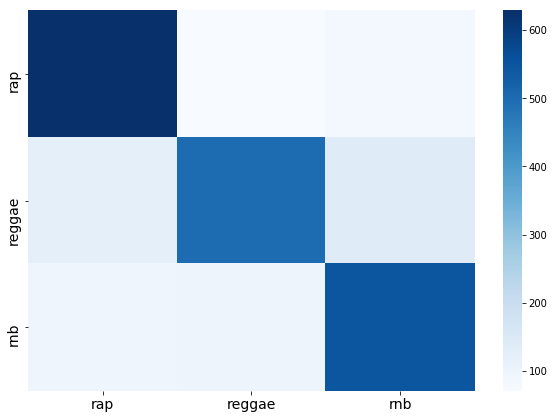

In [19]:
conf_matrix =  confusion_matrix(y_test, gbm.predict(X_test), labels=labels);
print(conf_matrix)
plt.figure(figsize=(10,7))
plt.xticks(size=14)
plt.yticks(size=14, rotation=45)
sns.heatmap(conf_matrix, cmap='Blues', xticklabels=labels, yticklabels=labels);

### Reggae songs predicted as rap

In [20]:
X_test_names['predictions'] = gbm.predict(X_test)
X_test_names['genre'] = y_test

In [21]:
X_test_names[(X_test_names.genre=='reggae')&
            (X_test_names.predictions=='rap')][['name','track','genre','predictions']]

,name,track,genre,predictions
4308,Rootz Underground,Climbing to the Rootz (Album Version),reggae,rap
6803,Morgan Heritage,The Fight,reggae,rap
6902,Sizzla,Attack,reggae,rap
7465,Mad Professor,Creation Dub,reggae,rap
5368,Marcia Griffiths,My Life,reggae,rap
7616,Admiral Bailey,Mi Big Up,reggae,rap
5012,Johnny Prez,Hitokiri,reggae,rap
6359,Born Jamericans,C'yaan Done,reggae,rap
6976,Grace Jones,Corporate Cannibal,reggae,rap
3974,Natasja,Mr. X,reggae,rap
